In [1]:
import pandas as pd
import numpy as np
import os, sys, datetime, pickle
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.tabular import *

In [2]:
path = '../data'
apply_log = False
TSColStart = 6
MakeValidation = True

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def read_data():
    print('Reading files...')
    calendar = pd.read_csv('../data/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('../data/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

In [5]:
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    calendar[["event_name_1", "event_type_1",
              "event_name_2", "event_type_2"]] = calendar[["event_name_1", "event_type_1",
                                                           "event_name_2", "event_type_2"]].fillna("None")
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [ ]:
calendar, sell_prices, sales_train_validation, submission = read_data()
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)


c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
data.head(5)

In [ ]:
# Handling missing values
data = data.sort_values(["state_id", "store_id", "cat_id", "dept_id", "item_id", "date"])

In [ ]:
data.columns

In [11]:
data.reset_index(drop=True, inplace=True)

AssertionError: Number of manager items must equal union of block items
# manager items: 18, # tot_items: 17

In [ ]:
data["sell_price"] = data.groupby(['store_id', 'item_id'])["sell_price"].fillna(method="ffill")

In [ ]:
data.columns

In [ ]:
# adding data variables
add_datepart(data, 'date')

In [17]:
print(df2.shape)

#data_bkup = df2.copy()

test_df = df2.loc[df2.date_rank > min_val_idx].copy().reset_index(drop=False)
df2 = df2.loc[df2.date_rank <= min_val_idx].copy().reset_index(drop=False)

print(df2.shape, test_df.shape)

(11677670, 35)
(9329940, 36) (2347730, 36)


In [19]:
procs=[FillMissing, Categorify, Normalize]

In [20]:
cat_vars = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'weekday', 'wday',
    'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI', 'Month', 'Week', 'Day', 'Dayofweek',
    'Dayofyear'
]

cont_vars = ['sell_price', 'Year', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
    'Is_year_end', 'Is_year_start', 'Elapsed']

In [21]:
df2.columns

Index(['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'date_rank', 'units_sold', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Elapsed'],
      dtype='object')

In [22]:
dep_var = ['units_sold']
df2 = df2[cat_vars + cont_vars + dep_var + ['date_rank']].copy()

In [27]:
df2['date_rank'].nunique(), df2['date_rank'].min(), df2['date_rank'].max()

(459, 1, 459)

In [24]:
valid_idx = df2.index[df2['date_rank'] > 400].tolist()

In [25]:
data = (TabularList.from_df(df2, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(valid_idx=valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

C:\Users\Deepak\Miniconda3\envs\Dev\lib\site-packages\fastai\data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [26]:
data.show_batch(5)

item_id,dept_id,cat_id,store_id,state_id,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Month,Week,Day,Dayofweek,Dayofyear,sell_price_na,sell_price,Year,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,target
HOUSEHOLD_1_113,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,Wednesday,5,7,2011,None,None,None,None,1,1,1,7,27,6,2,187,True,-0.2353,0.0000,-0.1931,-0.1838,-0.0995,-0.0995,0.0000,0.0000,0.0623,0.0
HOUSEHOLD_2_107,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,Saturday,1,7,2011,None,None,None,None,0,0,0,7,30,30,5,211,False,3.3000,0.0000,-0.1931,-0.1838,-0.0995,-0.0995,0.0000,0.0000,0.3340,0.0
HOBBIES_1_376,HOBBIES_1,HOBBIES,CA_3,CA,Monday,3,7,2011,None,None,None,None,0,0,0,7,30,25,0,206,True,-0.2353,0.0000,-0.1931,-0.1838,-0.0995,-0.0995,0.0000,0.0000,0.2774,0.0
HOBBIES_2_138,HOBBIES_2,HOBBIES,CA_3,CA,Saturday,1,6,2011,None,None,None,None,1,0,0,6,22,4,5,155,True,-0.2353,0.0000,-0.1931,-0.1838,-0.0995,-0.0995,0.0000,0.0000,-0.3000,0.0
HOUSEHOLD_1_012,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,Saturday,1,7,2011,None,None,None,None,0,0,0,7,28,16,5,197,False,0.0099,0.0000,-0.1931,-0.1838,-0.0995,-0.0995,0.0000,0.0000,0.1755,0.0


## Model

In [28]:
if apply_log:
    max_log_y = np.log(np.max(df['units_sold'])*1.5)
    y_range = torch.tensor([0, max_log_y], device=defaults.device)
else:
    max_y = np.max(df2['units_sold'])*1.5
    min_y = np.min(df2['units_sold']) - 0.5*(np.min(df2['units_sold']))
    y_range = torch.tensor([min_y, max_y], device=defaults.device)

In [29]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range) #, metrics=[root_mean_squared_error, explained_variance]

In [33]:
learn.batch_size = 16

In [34]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3050, 143)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(4, 3)
    (5): Embedding(8, 5)
    (6): Embedding(8, 5)
    (7): Embedding(12, 6)
    (8): Embedding(2, 2)
    (9): Embedding(26, 10)
    (10): Embedding(6, 4)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(12, 6)
    (17): Embedding(46, 14)
    (18): Embedding(32, 11)
    (19): Embedding(8, 5)
    (20): Embedding(307, 40)
    (21): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=295, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=Fa

In [35]:
#learn.loss_func = mean_squared_logarithmic_error

In [36]:
learn.lr_find()

epoch     train_loss  valid_loss  time    
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


OSError: [Errno 22] Invalid argument

C:\Users\Deepak\Miniconda3\envs\Dev\lib\site-packages\fastai\sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


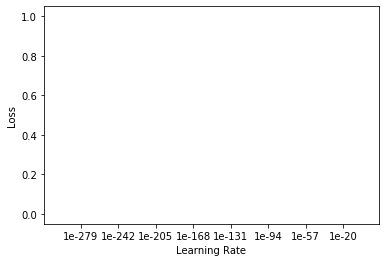

In [64]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch     train_loss  valid_loss  time    


OSError: [Errno 22] Invalid argument

In [67]:
learn.save('1')

C:\Users\Deepak\Miniconda3\envs\Dev\lib\site-packages\fastai\sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


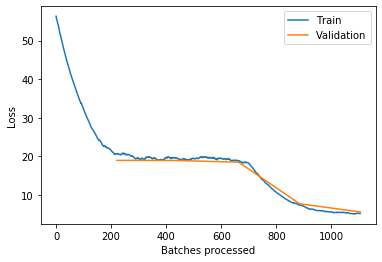

In [68]:
learn.recorder.plot_losses() #skip_start=10000

In [65]:
learn.load('1');

In [69]:
learn.fit_one_cycle(30, 3e-3)

epoch     train_loss  valid_loss  time    
0         5.218528    5.533182    01:20     
1         5.312062    5.510442    01:19     
2         5.283473    5.285662    01:19     
3         5.267607    5.269516    01:19     
4         5.165543    5.117702    01:19     
5         0.124798    0.419764    01:19     
6         0.071231    0.153742    01:20     
7         0.044483    0.151944    01:19     
8         0.051938    0.122983    01:19     
9         0.045594    0.167155    01:19     
10        0.039433    0.107382    01:19     
11        0.039977    0.133108    01:19     
12        0.033492    0.108156    01:19     
13        0.036188    0.135546    01:19     
14        0.037945    0.086150    01:19     
15        0.030553    0.090798    01:19     
16        0.034400    0.139861    01:19     
17        0.024445    0.101951    01:21     
18        0.017729    0.090229    01:19     
19        0.016978    0.101263    01:19     
20        0.017102    0.101608    01:19     
21        0.

In [70]:
train_preds=learn.get_preds(DatasetType.Train)
if apply_log:
    df[["PredConfirmedCases","PredFatalities"]] = pd.DataFrame((np.exp(train_preds[0].data).numpy() - 1.0))
else:
    df[["PredConfirmedCases","PredFatalities"]] = pd.DataFrame(train_preds[0].data.numpy())

if apply_diff:
    df[["ConfirmedCases", "Fatalities"]] = df.groupby(["ModelRegion"])[["ConfirmedCases", "Fatalities"]].cumsum()
    df['ConfirmedCases'] = df['ConfirmedCases'] + df['ConfirmedCases'].min() - 1
    df['Fatalities'] = df['Fatalities'] + df['Fatalities'].min() - 1

In [ ]:
df[["ConfirmedCases", "Fatalities"]]=df[["ConfirmedCases", "Fatalities"]].astype("int")
df.to_csv("../results/train_results.csv",index=False)

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
if apply_log:
    test_df[["ConfirmedCases","Fatalities"]] = np.exp(test_preds[0].data).numpy() - 1.0
else:
    test_df[["ConfirmedCases","Fatalities"]] = test_preds[0].data.numpy()

if apply_diff:
    test_df[["ConfirmedCases", "Fatalities"]] = test_df.groupby(["ModelRegion"])[["ConfirmedCases", "Fatalities"]].cumsum()
    test_df['ConfirmedCases'] = test_df['ConfirmedCases'] + df['ConfirmedCases'].min() - 1
    test_df['Fatalities'] = test_df['Fatalities'] + df['Fatalities'].min() - 1

In [ ]:
test_df[["ForecastId", "ConfirmedCases", "Fatalities"]]=test_df[["ForecastId", "ConfirmedCases", "Fatalities"]].astype("int")
test_df[["ForecastId", "ConfirmedCases", "Fatalities"]].to_csv("../results/submission.csv",index=False)